In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
import zipfile
import os

zip_path = "/content/data/sample_computer_vision.zip"
extract_path = "data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
!file /content/data/hymenoptera_data.zip

/content/data/hymenoptera_data.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/sample_computer_vision'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU 사용 중:", torch.cuda.get_device_name(0))
print(f"Using {device} device")

GPU 사용 중: Tesla T4
Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


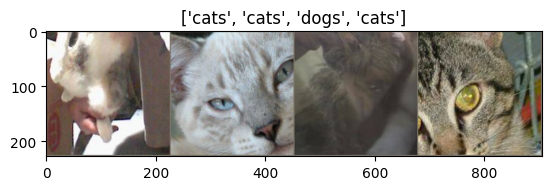

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate

Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Visualizing the model predictions
Generic function to display predictions for a few images

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
Load a pretrained model and reset final fully connected layer.

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5222 Acc: 0.7784
val Loss: 0.3290 Acc: 0.8250

Epoch 1/24
----------
train Loss: 0.5231 Acc: 0.7874
val Loss: 0.4965 Acc: 0.8250

Epoch 2/24
----------
train Loss: 0.5256 Acc: 0.7884
val Loss: 0.1437 Acc: 0.9750

Epoch 3/24
----------
train Loss: 0.4975 Acc: 0.8024
val Loss: 0.2515 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4683 Acc: 0.8253
val Loss: 0.1356 Acc: 0.9650

Epoch 5/24
----------
train Loss: 0.5045 Acc: 0.8124
val Loss: 0.2517 Acc: 0.9450

Epoch 6/24
----------
train Loss: 0.4509 Acc: 0.8303
val Loss: 0.1507 Acc: 0.9500

Epoch 7/24
----------
train Loss: 0.3394 Acc: 0.8583
val Loss: 0.1512 Acc: 0.9500

Epoch 8/24
----------
train Loss: 0.2570 Acc: 0.8912
val Loss: 0.1293 Acc: 0.9600

Epoch 9/24
----------
train Loss: 0.3131 Acc: 0.8653
val Loss: 0.1487 Acc: 0.9600

Epoch 10/24
----------
train Loss: 0.2653 Acc: 0.8772
val Loss: 0.1543 Acc: 0.9600

Epoch 11/24
----------
train Loss: 0.2698 Acc: 0.8932
val Loss: 0.1259 Acc: 0.9550

Ep

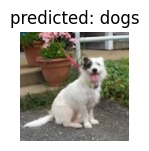

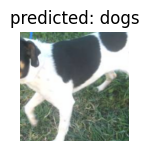

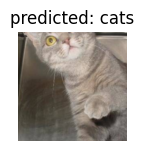

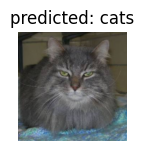

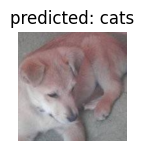

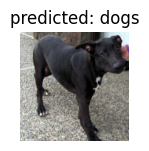

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5128 Acc: 0.7475
val Loss: 0.1246 Acc: 0.9600

Epoch 1/24
----------
train Loss: 0.4881 Acc: 0.7974
val Loss: 0.1995 Acc: 0.9500

Epoch 2/24
----------
train Loss: 0.3732 Acc: 0.8313
val Loss: 0.1401 Acc: 0.9500

Epoch 3/24
----------
train Loss: 0.4012 Acc: 0.8184
val Loss: 0.2668 Acc: 0.9100

Epoch 4/24
----------
train Loss: 0.4515 Acc: 0.8114
val Loss: 0.1179 Acc: 0.9700

Epoch 5/24
----------
train Loss: 0.4286 Acc: 0.8204
val Loss: 0.1317 Acc: 0.9600

Epoch 6/24
----------
train Loss: 0.4385 Acc: 0.8204
val Loss: 0.2279 Acc: 0.9300

Epoch 7/24
----------
train Loss: 0.3368 Acc: 0.8603
val Loss: 0.1068 Acc: 0.9750

Epoch 8/24
----------
train Loss: 0.3137 Acc: 0.8613
val Loss: 0.1736 Acc: 0.9500

Epoch 9/24
----------
train Loss: 0.3414 Acc: 0.8463
val Loss: 0.1106 Acc: 0.9650

Epoch 10/24
----------
train Loss: 0.3249 Acc: 0.8613
val Loss: 0.1153 Acc: 0.9800

Epoch 11/24
----------
train Loss: 0.3299 Acc: 0.8573
val Loss: 0.1287 Acc: 0.9650

Ep

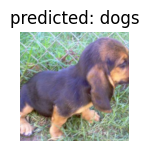

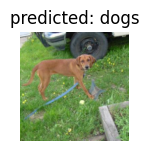

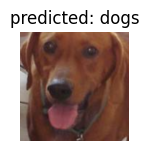

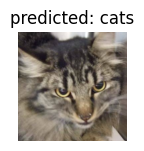

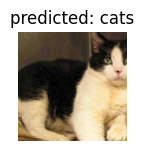

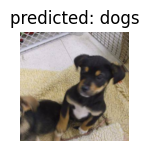

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()